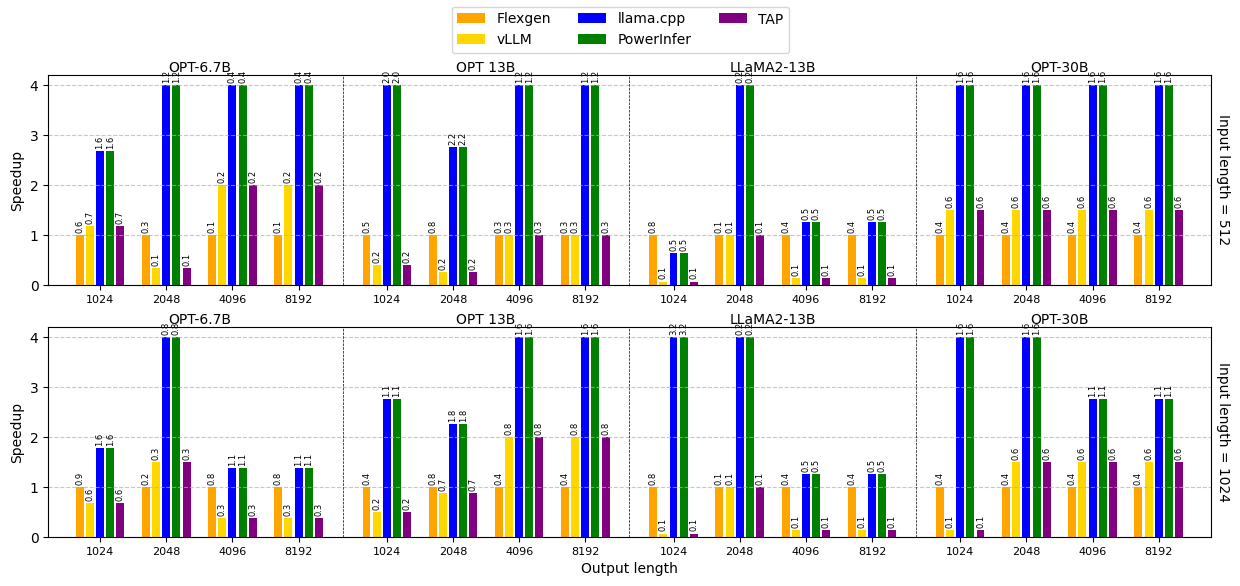

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

models = ['OPT-6.7B', 'OPT 13B', 'LLaMA2-13B', 'OPT-30B']
output_lengths = ['1024', '2048', '4096', '8192']
colors = ['orange', 'gold', 'blue', 'green', 'purple']
labels = ['Flexgen', 'vLLM', 'llama.cpp', 'PowerInfer', 'TAP']

# Tool function to normalize data (compute speedup relative to the first method)
def normalize(data):
    norm = []
    for model in data:
        norm_model = []
        for group in model:
            baseline = group[0]
            if baseline == 0:
                norm_group = [1] + [0] * (len(group) - 1)
            else:
                norm_group = [1] + [group[k] / baseline for k in range(1, len(group))]
            norm_model.append(norm_group)
        norm.append(norm_model)
    return norm

# Raw data (approximated generation speeds, extended for new config)
# Based on previous approximations, extended to 4 output lengths and 5 methods
raw_data1 = [
    # OPT-6.7B
    [[0.6, 0.7, 1.6, 1.6, 0.7], [0.3, 0.1, 1.7, 1.7, 0.1], [0.1, 0.2, 1.6, 1.6, 0.2], [0.1, 0.2, 1.6, 1.6, 0.2]],
    # OPT 13B
    [[0.5, 0.2, 2.6, 2.6, 0.2], [0.8, 0.2, 2.2, 2.2, 0.2], [0.3, 0.3, 2.0, 2.0, 0.3], [0.3, 0.3, 2.0, 2.0, 0.3]],
    # LLaMA2-13B
    [[0.8, 0.05, 0.5, 0.5, 0.05], [0.05, 0.05, 0.5, 0.5, 0.05], [0.4, 0.05, 0.5, 0.5, 0.05], [0.4, 0.05, 0.5, 0.5, 0.05]],
    # OPT-30B
    [[0.4, 0.6, 1.6, 1.6, 0.6], [0.4, 0.6, 1.6, 1.6, 0.6], [0.4, 0.6, 1.6, 1.6, 0.6], [0.4, 0.6, 1.6, 1.6, 0.6]]
]

raw_data2 = [
    # OPT-6.7B
    [[0.9, 0.6, 1.6, 1.6, 0.6], [0.2, 0.3, 1.6, 1.6, 0.3], [0.8, 0.3, 1.1, 1.1, 0.3], [0.8, 0.3, 1.1, 1.1, 0.3]],
    # OPT 13B
    [[0.4, 0.2, 1.1, 1.1, 0.2], [0.8, 0.7, 1.8, 1.8, 0.7], [0.4, 0.8, 1.9, 1.9, 0.8], [0.4, 0.8, 1.9, 1.9, 0.8]],
    # LLaMA2-13B
    [[0.8, 0.05, 8, 8, 0.05], [0.05, 0.05, 0.5, 0.5, 0.05], [0.4, 0.05, 0.5, 0.5, 0.05], [0.4, 0.05, 0.5, 0.5, 0.05]],
    # OPT-30B
    [[0.4, 0.05, 1.8, 1.8, 0.05], [0.4, 0.6, 1.9, 1.9, 0.6], [0.4, 0.6, 1.1, 1.1, 0.6], [0.4, 0.6, 1.1, 1.1, 0.6]]
]

# Change raw data to cap at about 4 times the baseline at most
for data in [raw_data1, raw_data2]:
    for model in data:
        for group in model:
            baseline = group[0]
            for k in range(1, len(group)):
                group[k] = min(group[k], baseline * 4)

# Normalized data (speedups)
data1 = normalize(raw_data1)
data2 = normalize(raw_data2)

within_spacing = 1.5  # Increased for larger gap between output lengths
between_extra = 0.5  # Decreased for smaller gap between models
x_list = []
current_x = 0.0
for i in range(len(models)):
    if i > 0:
        current_x += between_extra
    for j in range(len(output_lengths)):
        x_list.append(current_x)
        current_x += within_spacing
x = np.array(x_list)

mid_positions = [np.mean(x[i*len(output_lengths):(i+1)*len(output_lengths)]) for i in range(len(models))]

sep_pos = []
for i in range(1, len(models)):
    last_idx = i * len(output_lengths) - 1
    next_idx = i * len(output_lengths)
    sep = (x[last_idx] + x[next_idx]) / 2
    sep_pos.append(sep)

def plot_bar(ax, data, raw_data, input_length):
    num_methods = len(labels)
    len_output = len(output_lengths)
    width = 0.9 / num_methods  # Adjust width to fit groups
    gap = 0.05  # Gap between bars (baselines); increase this value for larger gaps
    max_height = max([max(group) for model in data for group in model])  # Compute max height for label placement
    for i, m in enumerate(models):
        for j, o in enumerate(output_lengths):
            ind = i * len_output + j
            pos = x[ind]
            for k in range(num_methods):
                height = data[i][j][k]
                raw_val = raw_data[i][j][k]
                offset = (k - (num_methods - 1) / 2.0) * (width + gap)
                bar = ax.bar(pos + offset, height, width, color=colors[k])
                height_offset = 0.05
                if height > 0:
                    ax.text(pos + offset, height + height_offset, f'{raw_val:.1f}', ha='center', va='bottom', fontsize=6, rotation=90)
                elif height == 0:
                    ax.text(pos + offset, height + height_offset, 'x', ha='center', va='bottom', fontsize=6, rotation=90)
    ax.set_xticks(x, output_lengths * len(models), fontsize=8)
    ax.set_ylabel('Speedup', fontsize=10)
    ax.margins(x=0.025)
    # Add horizontal grid lines
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    # Add model labels on top
    for i, m in enumerate(models):
        ax.text(mid_positions[i], max_height + 0.2, m, ha='center', va='bottom', fontsize=10)
    # Add vertical separators between models
    for sep in sep_pos:
        ax.axvline(x=sep, color='black', linestyle='--', linewidth=0.5)
    # Add input length label on the right, vertically
    ax.text(1.005, 0.5, f'Input length = {input_length}', transform=ax.transAxes, va='center', ha='left', rotation=270, fontsize=10)
    

plot_bar(ax1, data1, raw_data1, 512)
plot_bar(ax2, data2, raw_data2, 1024)

ax2.set_xlabel('Output length', fontsize=10)

# Legend with colored patches
handles = [Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10)

# fig.tight_layout(rect=[0.02, 0, 0.98, 0.95])
plt.show()